# **Most frequent landing page domains and prefix of articles across multiple Institutions**
## Exploring Publications in *OpenAlex*

#### What is analyzed
- The domains (e.g., publisher or repository websites) where articles from Swiss universities are most frequently hosted.
- The top domains per institution articles.
- The distribution and overlap of these domains across different institutions, visualized both as bar charts and as a heatmap.

#### Why is this analysis interesting
- Understanding where research is hosted reveals the role of different publishers and repositories in making research accessible, especially for local or regional audiences.
- The analysis highlights which domains are most important for the visibility and accessibility of research outputs in Switzerland.
- Performing this analysis without DOI gives us a closer look into other domains.

#### What can be observed including the DOI TLD?
- The most common domain is by far doi.org.
- The University of Zurich and the University of Geneva have the most diversity in terms of domains.
- The visualization shows both the concentration and diversity of domains across universities.

#### What can be observed excluding the DOI TLD?
- The most common domains for non-English articles is "pubmed.ncbi.nlm.nih.gov" followed by "serval.unil.ch".
- The last visualization gives us a closer look of the distribution of non doi.org-domains.

### Setup
#### Imports

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from collections import Counter
import time
from swiss_universities import swiss_unis

#### Response Validation

In [3]:
def validate_response(response):
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return {"group_by": [], "results": []}

## Analysis 1: Most frequent domains and prefix of institution articles

### Step 1: Extract Domains
Extract the domains from URLs

In [4]:
def extract_domain(url):
    if url:
        parsed = urlparse(url)
        return parsed.netloc
    return None

### Step 2: Fetch Articles
Fetch the articles for a specific institution.

In [5]:
# Set publication year
publication_year = 2024

In [ ]:
def fetch_articles_noDOI(institution_id, per_page=200, max_pages=5):
    page = 1
    articles = []
    while page <= max_pages:
        url = (
            f"https://api.openalex.org/works"
            f"?filter=authorships.institutions.lineage:{institution_id},"
            f"publication_year:{publication_year}"
            f"&per-page={per_page}&page={page}"
        )
        response = requests.get(url)
        data = validate_response(response)

        results = data.get("results", [])
        if not results:
            break
        
        # loop through each result
        for result in results: 
            # 'locations' is a list of dictionaries in metadata
            for loc in result.get("locations", []): 
                # extract URL of the article
                landing_url = loc.get("landing_page_url") 
                if landing_url:
                    articles.append(landing_url)

        page += 1
        # to avoid hitting the API too hard
        time.sleep(0.5)  

    return articles

### Step 3: Aggregate Domains for each Institution
What we're doing here step-by-step:
1. We create a list to store the domain data
2. We loop through each institution in the swiss_universities dictionary
3. For each institution, we fetch the articles of the specified publication year.
4. We extract the domain from each URL
5. We count the occurrences of each domain

    > Note: The full count is used, meaning publications that are available in more than one    repository are counted as one for each repository / location.
6. We append the results to the domain_data list
7. Finally, we print the domain data

In [ ]:
domain_data = []

for name, inst_id in swiss_unis.items():
    print(f"Processing {name}... ")
    urls = fetch_articles_noDOI(inst_id)
    domains = [extract_domain(url) for url in urls]
    clean_domains = [d for d in domains if d]  # Filter out None
    domain_counts = Counter(clean_domains)
    
    for domain, count in domain_counts.items():
        domain_data.append({
            "Institution": name,
            "Domain": domain,
            "Count": count
        })

Processing ETH Zurich... 
Processing University of Zurich... 
Processing EPFL... 
Processing University of Bern... 
Processing University of Basel... 
Processing University of St. Gallen... 
Processing University of Lucerne... 
Processing University of Fribourg... 
Processing University of Lausanne... 
Processing University of Geneva... 
Processing University of Neuchâtel... 
Processing Università della Svizzera italiana... 


### Step 4: Create DataFrame

In [8]:
domain_df = pd.DataFrame(domain_data)
# sort by Institution and Count
domain_df = domain_df.sort_values(["Institution", "Count"], ascending=[True, False]) 

#### Display DataFrame

In [9]:
domain_df

,Institution,Domain,Count
258,EPFL,doi.org,1072
263,EPFL,infoscience.epfl.ch,561
259,EPFL,pubmed.ncbi.nlm.nih.gov,533
262,EPFL,www.ncbi.nlm.nih.gov,346
260,EPFL,hdl.handle.net,273
...,...,...,...
1290,Università della Svizzera italiana,www.hope.uzh.ch,1
1291,Università della Svizzera italiana,mts.intechopen.com,1
1292,Università della Svizzera italiana,www.zora.uzh.ch,1
1293,Università della Svizzera italiana,arodes.hes-so.ch,1


### Step 5: Top N domains per Institution + Plot Bar Chart
We want to find the top 5 domains for each institution – for that we use a lambda function and use the `groupby` method to group by institution and get the top 5 domains based on the count. Then we reset the index to flatten the DataFrame.

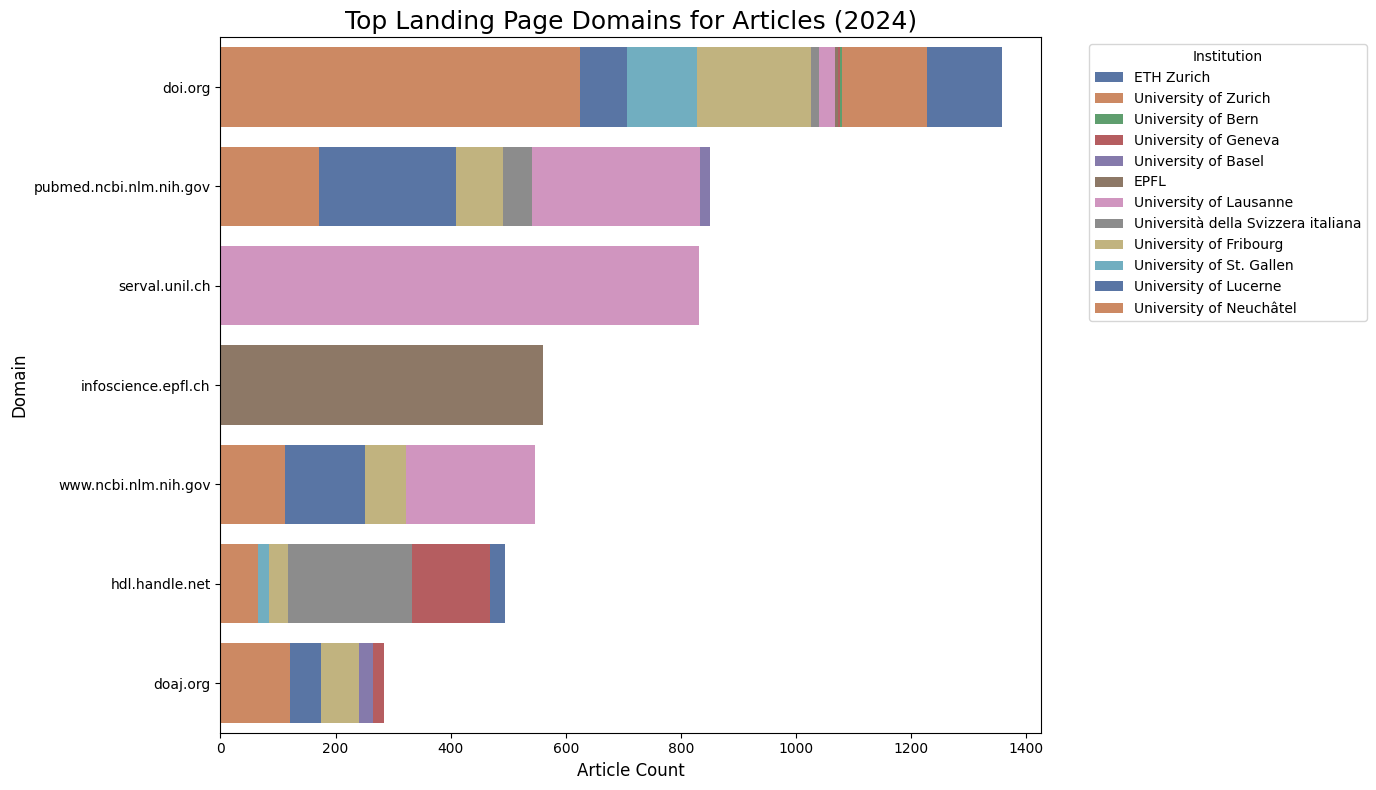

In [21]:
# find top 5 domains for each institution
top_n = 5
top_domains = domain_df.groupby("Institution").apply(
    lambda x: x.nlargest(top_n, "Count")
).reset_index(drop=True)

# Sort by count
top_domains = top_domains.sort_values("Count", ascending=False)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Create plot
sns.barplot(
    data=top_domains,
    y="Domain",
    x="Count",
    hue="Institution",
    palette="deep",
    dodge=False,
    ax=ax  # Pass the axes object to Seaborn
)

# Set labels and title
ax.set_title(f"Top Landing Page Domains for Articles (2024)", fontsize=18)
ax.set_xlabel("Article Count", fontsize=12)
ax.set_ylabel("Domain", fontsize=12)

# Adjust legend
ax.legend(title="Institution", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

### Step 6: Plot Faceted Bar Chart
Each facet represents an institution, and the bars within each facet show the top domains by count. We plot the top five domains for each institution


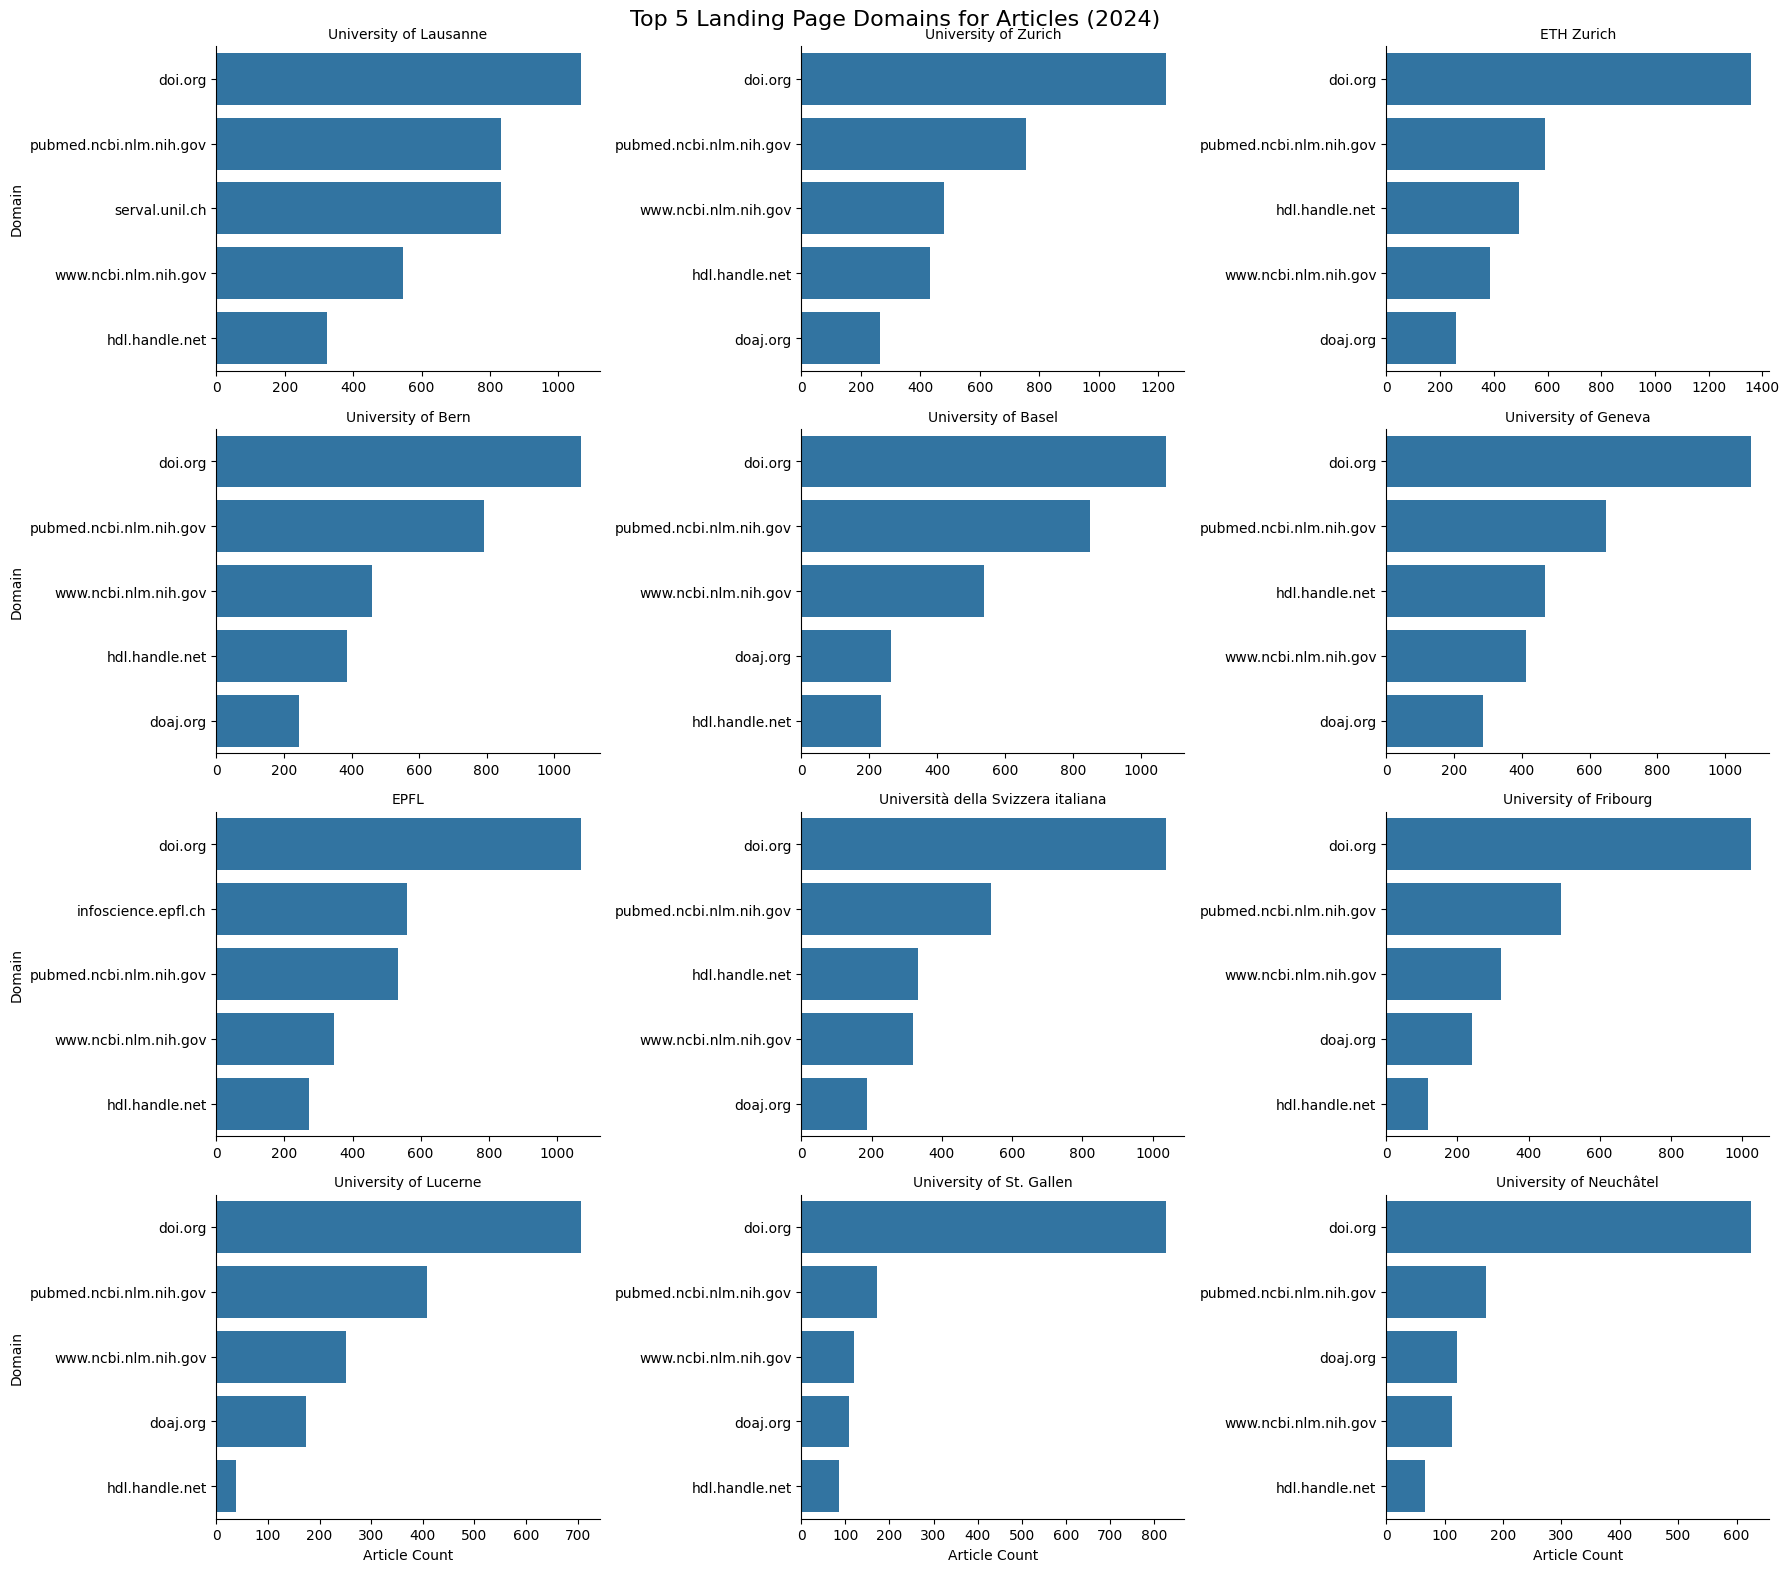

In [22]:
#ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Find top 5 domains for each institution
top_n = 5
top_domains = domain_df.groupby("Institution").apply(
    lambda x: x.nlargest(top_n, "Count")
).reset_index(drop=True)

# Sort institutions by total articles (optional, for ordering facets)
institution_order = top_domains.groupby("Institution")["Count"].sum().sort_values(ascending=False).index
top_domains["Institution"] = pd.Categorical(top_domains["Institution"], categories=institution_order, ordered=True)

# Create faceted bar chart
g = sns.FacetGrid(top_domains, col="Institution", col_wrap=3, height=4, aspect=1.5, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="Count", y="Domain", dodge=False)
g.set_titles("{col_name}")
g.set_axis_labels("Article Count", "Domain")
g.fig.suptitle(f"Top {top_n} Landing Page Domains for Articles (2024)", fontsize=16)
g.tight_layout()
plt.show()

## Analysis 2: Most frequent domains and prefix of articles **without doi.org**

### Step 1: Extract Domains
Extract the domains from URLs and exclude DOI domains

In [12]:
def extract_domain_noDOI(url):
    if url:
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Exclude DOI-like resolver domains
        exclude = {"doi.org", "dx.doi.org", "hdl.handle.net", "www.doi.org"}
        if domain in exclude:
            return None
        return domain
    return None

### Step 2: Fetch Articles
Fetch non-English articles for a specific institution

In [13]:
# Set publication year
publication_year = 2024

In [ ]:
def fetch_articles_noDOI(institution_id, per_page=200, max_pages=5):
    page = 1
    articles = []
    while page <= max_pages:
        url = (
            f"https://api.openalex.org/works"
            f"?filter=authorships.institutions.lineage:{institution_id},"
            f"publication_year:{publication_year}"
            f"&per-page={per_page}&page={page}"
        )
        response = requests.get(url)
        data = validate_response(response)

        results = data.get("results", [])
        if not results:
            break
        
        # loop through each result
        for result in results:
            # 'locations' is a list of dictionaries in metadata
            for loc in result.get("locations", []):
                # extract URL of the article
                landing_url = loc.get("landing_page_url")
                if landing_url:
                    articles.append(landing_url)

        page += 1
        # to avoid hitting the API too hard
        time.sleep(0.5)  

    return articles


### Step 3: Aggregate Domains for each Institution
> here we do the same as above, just with the data without doi.org

In [ ]:
domain_data_noDOI = []

for name, inst_id in swiss_unis.items():
    print(f"Processing {name}...")
    urls = fetch_articles_noDOI(inst_id)  
    domains = [extract_domain_noDOI(url) for url in urls]
    clean_domains = [d for d in domains if d]  # Filter out None
    
    domain_counts = Counter(clean_domains)

    for domain, count in domain_counts.items():
        domain_data_noDOI.append({
            "Institution": name,
            "Domain": domain,
            "Count": count
        })


Processing ETH Zurich...
Processing University of Zurich...
Processing EPFL...
Processing University of Bern...
Processing University of Basel...
Processing University of St. Gallen...
Processing University of Lucerne...
Processing University of Fribourg...
Processing University of Lausanne...
Processing University of Geneva...
Processing University of Neuchâtel...
Processing Università della Svizzera italiana...


### Step 4: Create DataFrame

In [16]:
domain_df_noDOI = pd.DataFrame(domain_data_noDOI)
# sort by Institution and Count
domain_df_noDOI = domain_df_noDOI.sort_values(by=["Institution", "Count"], ascending=[True, False])

#### Display DataFrame

In [17]:
domain_df_noDOI

,Institution,Domain,Count
255,EPFL,infoscience.epfl.ch,561
252,EPFL,pubmed.ncbi.nlm.nih.gov,533
254,EPFL,www.ncbi.nlm.nih.gov,346
261,EPFL,doaj.org,231
260,EPFL,www.osti.gov,109
...,...,...,...
1256,Università della Svizzera italiana,www.hope.uzh.ch,1
1257,Università della Svizzera italiana,mts.intechopen.com,1
1258,Università della Svizzera italiana,www.zora.uzh.ch,1
1259,Università della Svizzera italiana,arodes.hes-so.ch,1


### Step 5: Top N domains per Institution + Plot Bar Chart
> same as above

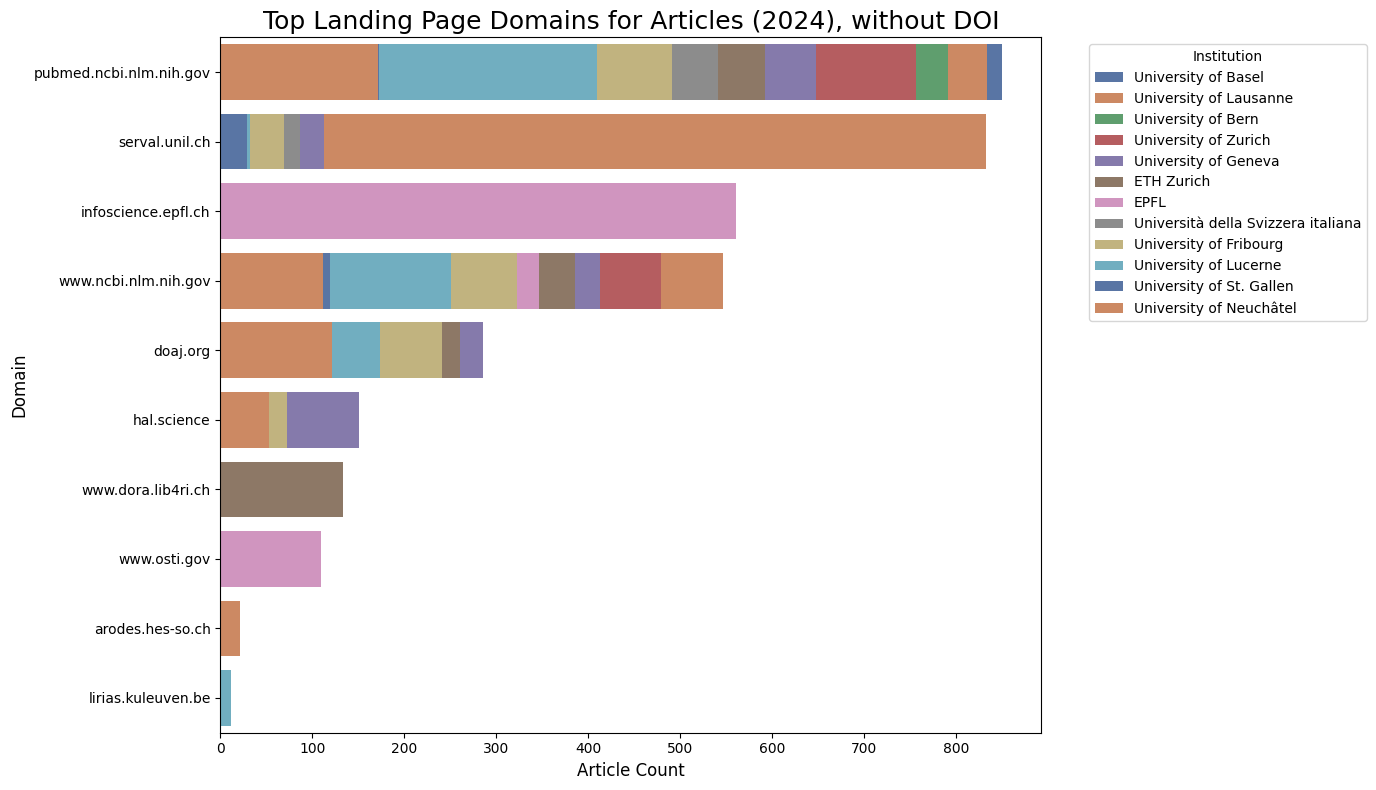

In [24]:
# find top 5 domains for each institution
top_n = 5
top_domains = domain_df_noDOI.groupby("Institution").apply(
    lambda x: x.nlargest(top_n, "Count")
).reset_index(drop=True)

# Sort by count
top_domains = top_domains.sort_values('Count', ascending=False)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the bar chart
sns.barplot(
    data=top_domains,
    y="Domain",
    x="Count",
    hue="Institution",
    palette="deep",
    dodge=False,
    ax=ax  # Pass the axes object to Seaborn
)

# Set labels and title
ax.set_title(f"Top Landing Page Domains for Articles ({publication_year}), without DOI", fontsize=18)
ax.set_xlabel("Article Count", fontsize=12)
ax.set_ylabel("Domain", fontsize=12)

# Adjust legend
ax.legend(title="Institution", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

### Step 6: Plot Faceted Bar Chart

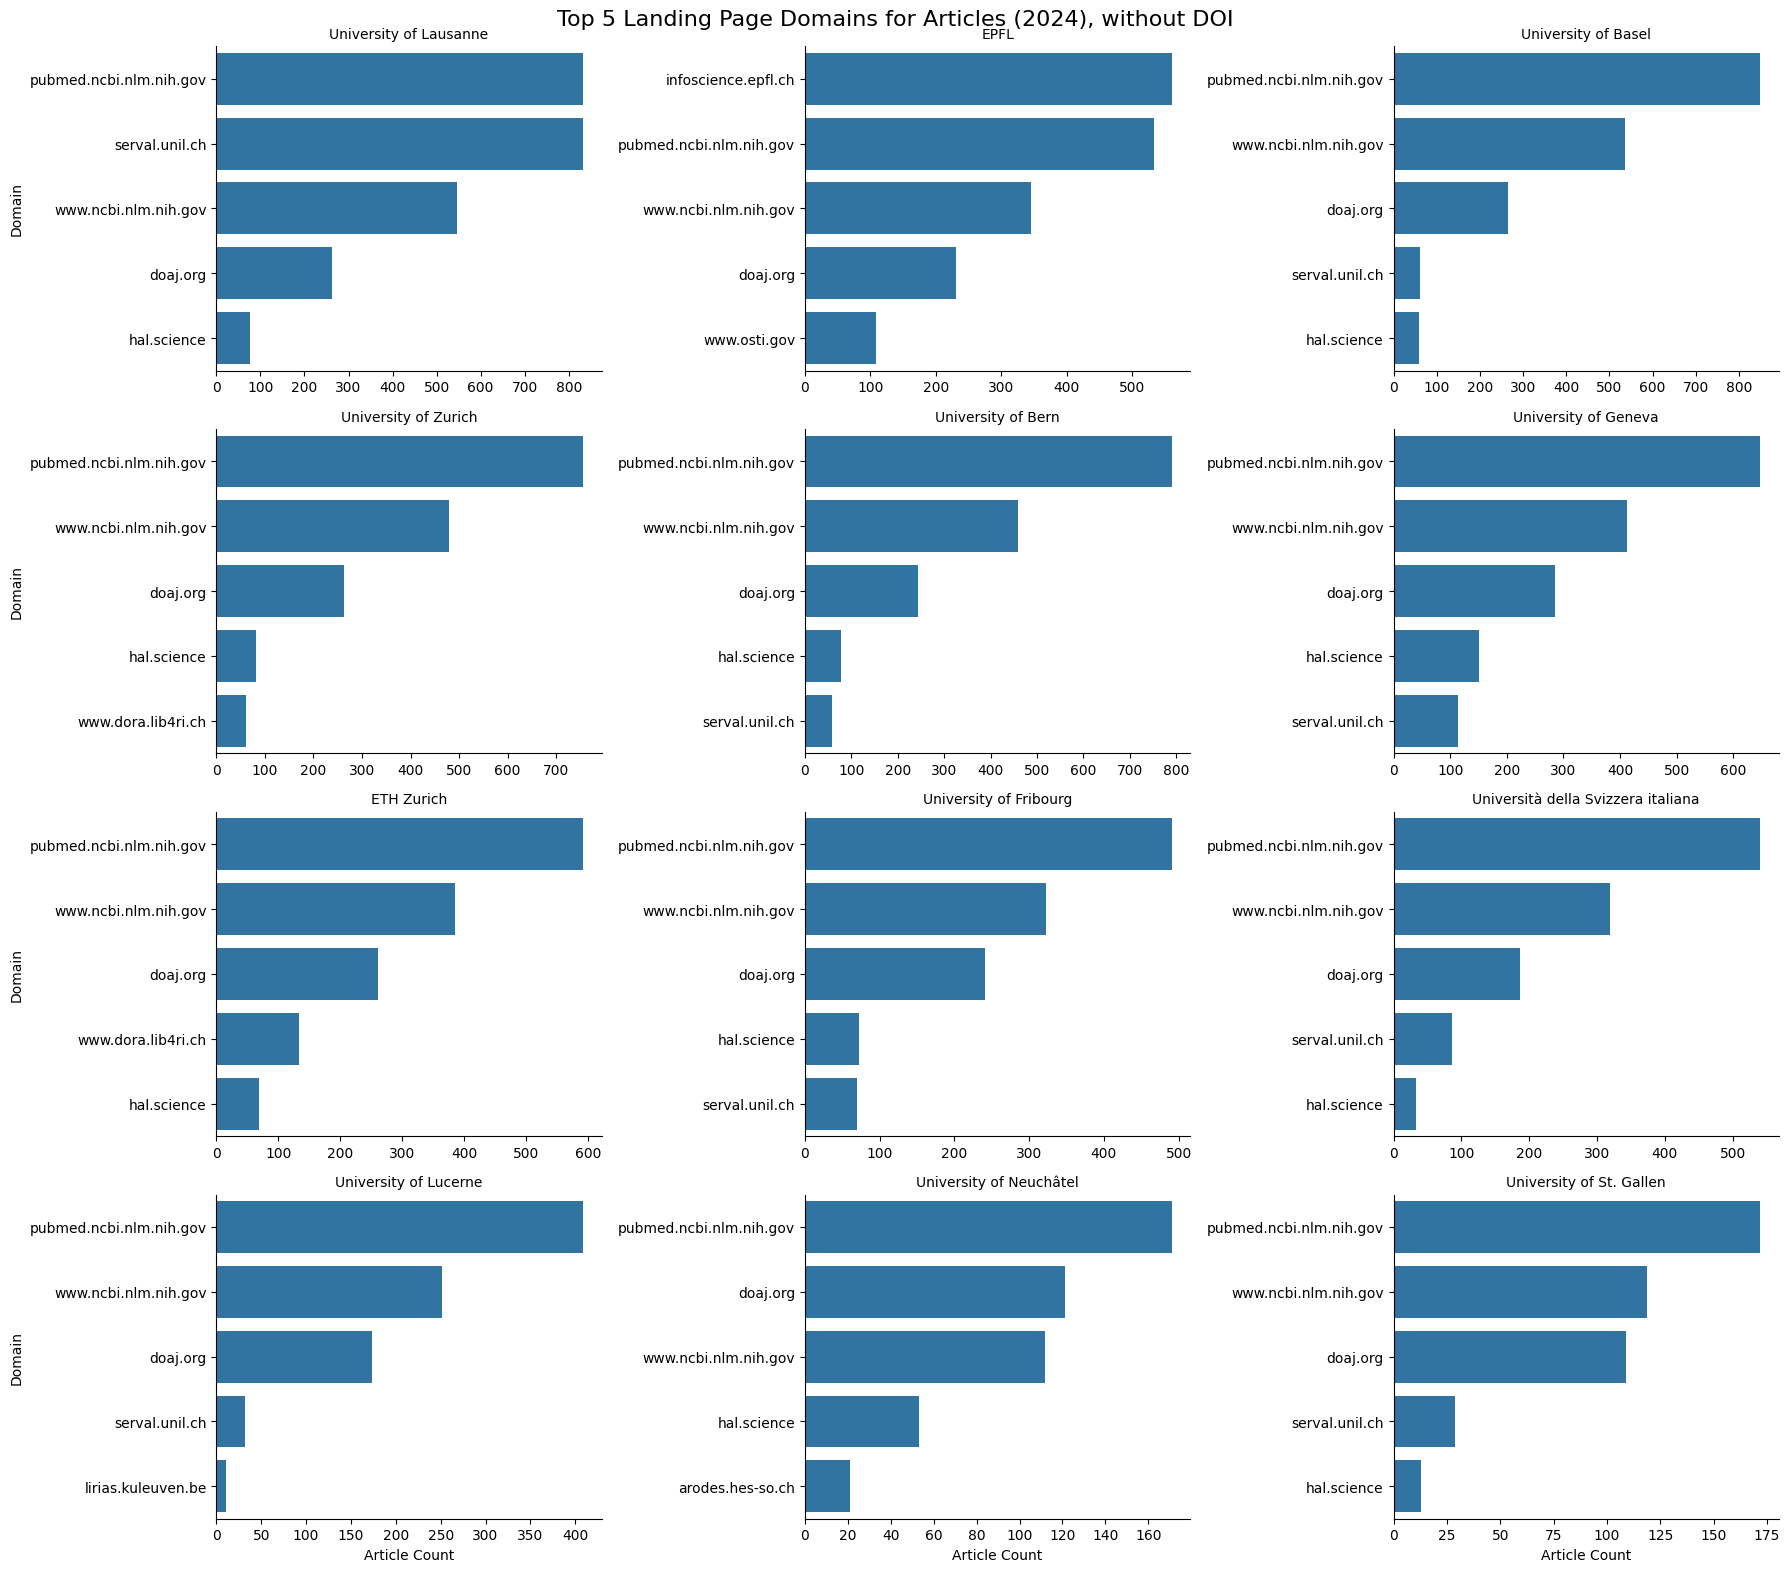

In [25]:
#ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Find top 5 domains for each institution
top_n = 5
top_domains = domain_df_noDOI.groupby("Institution").apply(
    lambda x: x.nlargest(top_n, "Count")
).reset_index(drop=True)

# Sort institutions by total non-English articles (optional, for ordering facets)
institution_order = top_domains.groupby("Institution")["Count"].sum().sort_values(ascending=False).index
top_domains["Institution"] = pd.Categorical(top_domains["Institution"], categories=institution_order, ordered=True)

# Create faceted bar chart
g = sns.FacetGrid(top_domains, col="Institution", col_wrap=3, height=4, aspect=1.5, sharex=False, sharey=False)
g.map_dataframe(sns.barplot, x="Count", y="Domain", dodge=False)
g.set_titles("{col_name}")
g.set_axis_labels("Article Count", "Domain")
g.fig.suptitle(f"Top {top_n} Landing Page Domains for Articles ({publication_year}), without DOI", fontsize=16)
g.tight_layout()
plt.show()